# ASL-alphabets Prediction using Transfer Learning on AWS SageMaker

This notebook walks through implementation of Image Classification Machine Learning Model to alphabets based on ASL-alphabets to translate ASL gesture to English

* We have used data from Kaggle, link is mentioned below:
https://www.kaggle.com/datasets/shadman0786/asl-alphabet-cnn

* We will be using a pretrained Resnet50 model from pytorch vision library
(https://pytorch.org/vision/master/generated/torchvision.models.resnet50.html)

* We will add two Fully connected Neural Network layers on top of the above Resnet50 model
* We will use concept of Transfer learning therefore we will be freezing all the existing Convolutional layers in the pretrained Resnet50 model and only change the gradients for the two fully connected layers
* We perform Hyperparameter tuning, to get the optimal best hyperparameters to be used in our model
* We have added configuration for Profiling and Debugging our training model by adding relevant hooks in Training and Testing (evel) phases
* We will then deploy our Model, for deploying we have created inference script. The inference script will be overriding a few functions that will be used by our deployed endpoint for making inferences/predictions.
* At the end, we would be testing our model with some test images of dogs, to verify if the model is working as per our expectations.

In [2]:
# Install any packages that you might need
# need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-910293992207


## Dataset

The dataset we used for this project is ASL-alphabet dataset that can be found in the [link]https://www.kaggle.com/datasets/shadman0786/asl-alphabet-cnn

It comprises:
-asl_alphabet<br> 
* Test<br> 
    -- A (600) <br> 
    -- B (600) <br> 
    ........ <br>
    -- Z (600) 
* Train folder<br> 
    -- A (2400) <br> 
    -- B (2400) <br> 
    ........ <br>
    -- Z (2400) 

In [4]:
!pip install kaggle

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 1.3 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 1.6 MB/s eta 0:00:00ta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=84318f0291db295d9ebd2181d4c19eb9b4b25bd213fb8268dcc13bf2dcfba399
  Stored in directory: /root/.cache/pip/wheels/11/ec/8f/80c32ff2501f7b1a76f4df651a0242314d229a5d3e5130bd01
Successfully built kaggle

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [5]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "user_name"
kaggle_key = "key"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [8]:
!kaggle datasets download -d shadman0786/asl-alphabet-cnn

100%|██████████████████████████████████████▊| 1.02G/1.02G [00:04<00:00, 226MB/s]
100%|███████████████████████████████████████| 1.02G/1.02G [00:10<00:00, 100MB/s]


In [9]:
# unzipping dogs_vs_cats.zip file using quiet
!unzip -q asl-alphabet-cnn.zip # -q for quiet

In [10]:
# uploading data in AWS S3
import time
tic = time.clock()
prefix ="asl_alphabet"
print("Starting to upload asl_alphabet")

inputs = sagemaker_session.upload_data(path="asl_alphabet", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")
toc = time.clock()
print(f'time consumed: {toc - tic}')

Starting to upload asl_alphabet
Input path ( S3 file path ): s3://sagemaker-us-east-1-910293992207/asl_alphabet


In [9]:
inputs = "s3://sagemaker-us-east-1-910293992207/asl_alphabet"
print(f"Input path ( S3 file path ): {inputs}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-910293992207/asl_alphabet


In [11]:
path = "./asl_alphabet/train"
path

'./asl_alphabet/train'

# Data Visualization

Category shown below is : A


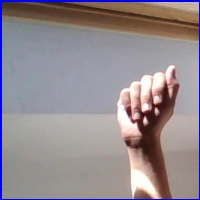

Category shown below is : B


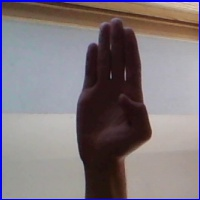

Category shown below is : C


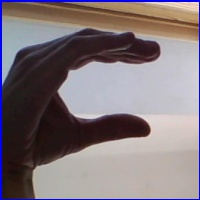

Category shown below is : D


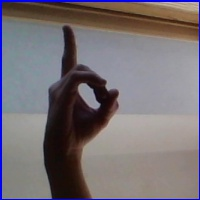

Category shown below is : E


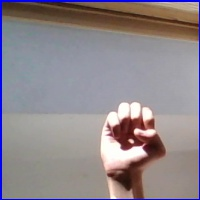

Category shown below is : F


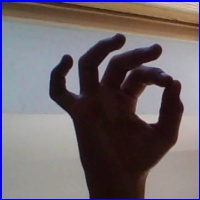

Category shown below is : G


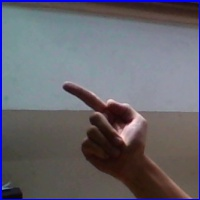

Category shown below is : H


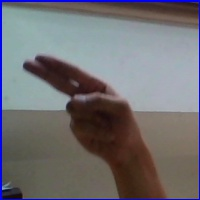

Category shown below is : I


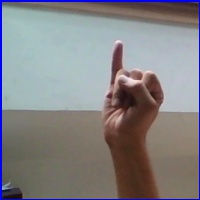

Category shown below is : J


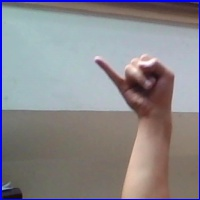

Category shown below is : K


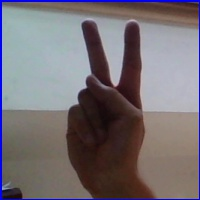

Category shown below is : L


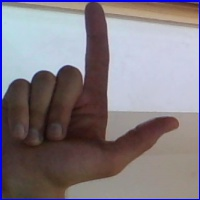

Category shown below is : M


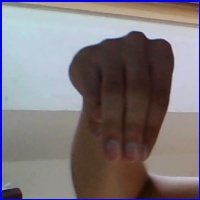

Category shown below is : N


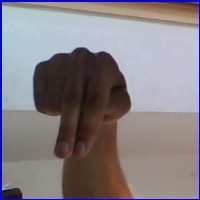

Category shown below is : O


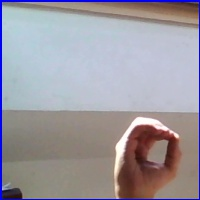

Category shown below is : P


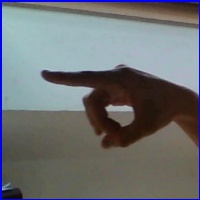

Category shown below is : Q


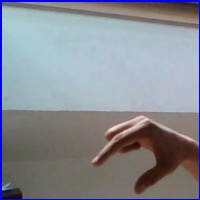

Category shown below is : R


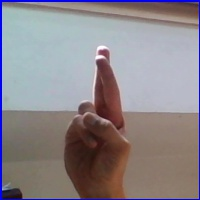

Category shown below is : S


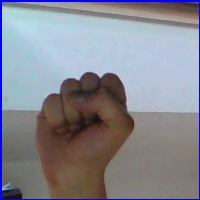

Category shown below is : T


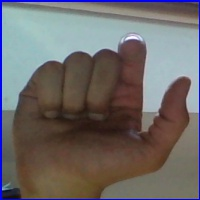

Category shown below is : U


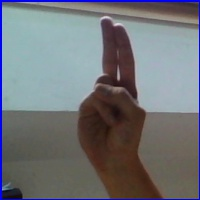

Category shown below is : V


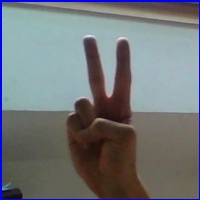

Category shown below is : W


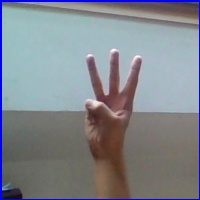

Category shown below is : X


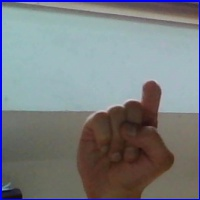

Category shown below is : Y


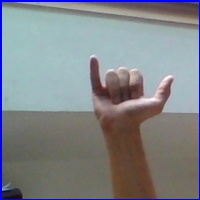

Category shown below is : Z


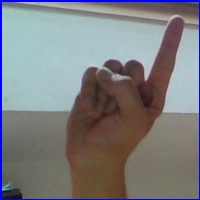

In [24]:
from PIL import Image
import io
import os
import numpy as np

path = ["./asl_alphabet/train/A/A1000.jpg"
        ,"./asl_alphabet/train/B/B1000.jpg"
       ,"./asl_alphabet/train/C/C1000.jpg"
       ,"./asl_alphabet/train/D/D1000.jpg"
       ,"./asl_alphabet/train/E/E1000.jpg"
       ,"./asl_alphabet/train/F/F1000.jpg"
       ,"./asl_alphabet/train/G/G1000.jpg"
       ,"./asl_alphabet/train/H/H1000.jpg"
       ,"./asl_alphabet/train/I/I1000.jpg"
       ,"./asl_alphabet/train/J/J1000.jpg"
       ,"./asl_alphabet/train/K/K1000.jpg"
       ,"./asl_alphabet/train/L/L1000.jpg"
       ,"./asl_alphabet/train/M/M1000.jpg"
       ,"./asl_alphabet/train/N/N1000.jpg"
       ,"./asl_alphabet/train/O/O1000.jpg"
       ,"./asl_alphabet/train/P/P1000.jpg"
       ,"./asl_alphabet/train/Q/Q1000.jpg"
       ,"./asl_alphabet/train/R/R1000.jpg"
       ,"./asl_alphabet/train/S/S1000.jpg"
       ,"./asl_alphabet/train/T/T1000.jpg"
       ,"./asl_alphabet/train/U/U1000.jpg"
       ,"./asl_alphabet/train/V/V1000.jpg"
       ,"./asl_alphabet/train/W/W1000.jpg"
       ,"./asl_alphabet/train/X/X1000.jpg"
       ,"./asl_alphabet/train/Y/Y1000.jpg"
       ,"./asl_alphabet/train/Z/Z1000.jpg"]
#address = ["/A601", "/A602"]
for a in path:
    with open(a , "rb") as f:
        payload = f.read()
        print(f"Category shown below is : {a[23:24]}")
        display(Image.open(io.BytesIO(payload)))

## Hyperparameter Tuning
The ResNet50 model with a two Fully connected Linear NN layer's is used for this image classification problem. ResNet-50 is 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database. Furthermore the model has a lot of trainable parameters, which indicates a deep architecture that makes it better for image recognition The optimizer that we will be using for this model is AdamW ( For more info refer : https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html ) Hence, the hyperparameters selected for tuning were: Learning rate - default(x) is 0.001 , so we have selected 0.01x to 100x range for the learing rate eps - defaut is 1e-08 , which is acceptable in most cases so we have selected a range of 1e-09 to 1e-08 Weight decay - default(x) is 0.01 , so we have selected 0.1x to 10x range for the weight decay Batch size -- selected only two values [ 64, 128 ]

In [5]:
#Importing all the required modules fomr tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a different( more correct or better) way to calulate the weight decay related computations
# So we will be using weight_decay and eps hyperparamter tuning as well , along with the lerning rate and batchsize params
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [6]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "asl-alphabet-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [8]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-08 11:32:06 Starting - Found matching resource for reuse
2023-02-08 11:32:06 Downloading - Downloading input data
2023-02-08 11:32:06 Training - Training image download completed. Training in progress.
2023-02-08 11:32:06 Uploading - Uploading generated training model
2023-02-08 11:32:06 Completed - Resource reused by training job: pytorch-training-230208-1046-003-f9ccea2c


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'eps': '8.894659223977433e-09',
 'lr': '0.0009034645151607949',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-cat-classification-hpo-2023-02-08-10-46-41-371"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-910293992207/dog-cat-classification-hpo-2023-02-08-10-46-41-371/source/sourcedir.tar.gz"',
 'weight_decay': '0.0029532014437717905'}

In [9]:
# Below are the hyperparameters markdown, that can be used instead of re-running the entire hypertuning job

In [12]:
{'batch_size': 64, 'eps': '8.894659223977433e-09', 'lr': '0.0009034645151607949', 'weight_decay': '0.0029532014437717905'}

{'batch_size': 64,
 'eps': '8.894659223977433e-09',
 'lr': '0.0009034645151607949',
 'weight_decay': '0.0029532014437717905'}

In [13]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 64, 'eps': '8.894659223977433e-09', 'lr': '0.0009034645151607949', 'weight_decay': '0.0029532014437717905'}


## Model Profiling and Debugging

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [10]:
# Setting up debugger and profiler rules and configs
from  sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [11]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2023-02-10 05:01:23 Starting - Starting the training job...
2023-02-10 05:01:38 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-02-10 05:02:51 Downloading - Downloading input data.........
2023-02-10 05:04:25 Training - Downloading the training image......
2023-02-10 05:05:19 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-10 05:05:30,156 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-10 05:05:30,184 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-10 05:05:30,187 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-10 05:05:30,426 sagemaker-training-toolkit INFO     Inv

In [12]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [13]:
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2023-02-10-05-01-23-323
Client: <botocore.client.SageMaker object at 0x7fe3998f0090>
Description: {'TrainingJobName': 'pytorch-training-2023-02-10-05-01-23-323', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:910293992207:training-job/pytorch-training-2023-02-10-05-01-23-323', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'eps': '"8.894659223977433e-09"', 'lr': '"0.0009034645151607949"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2023-02-10-05-01-23-323"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/source/sourcedir.tar.gz"', 'weight_decay': '"0.0029532014437717905"'}, 'AlgorithmSpecif

In [14]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-10 05:27:14.742 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-10 05:27:14.755 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/debug-output
[2023-02-10 05:27:15.340 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4784 more expected)', IncompleteRead(0 bytes read, 4784 more expected)) while reading s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/debug-output/index/000000000/000000000960_worker_0.json . Will retry now


In [15]:
trial.tensor_names() #all the tensor names

[2023-02-10 05:27:24.262 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-10 05:27:25.286 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [16]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

218

In [17]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

544

In [18]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


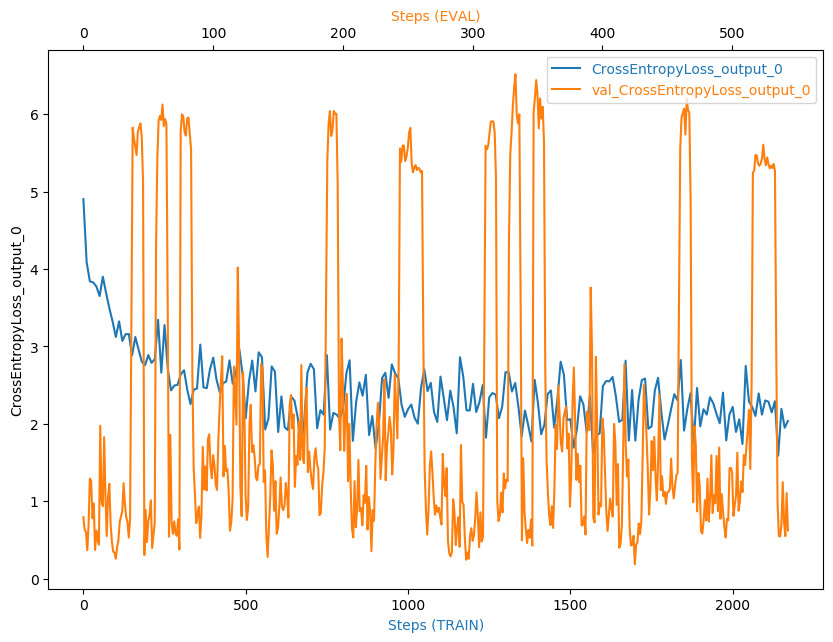

In [19]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [20]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/rule-output


In [21]:
! aws s3 ls {rule_output_path} --recursive

2023-02-10 05:25:31     418831 pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-10 05:25:30     274643 pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-10 05:25:25        192 pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-10 05:25:25      15203 pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-10 05:25:25        126 pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-10 05:25:26        343 pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-10 05:25:26       2355 pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-re

In [22]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-91029399220

In [23]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [24]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/root/profiler_report.zip'

In [61]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [25]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    ## TODO: Set config options
    enable_capture = True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

In [26]:
# TODO: Deploy your model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge", data_capture_config=data_capture_config)

------!

In [29]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-910293992207/pytorch-training-2023-02-10-05-01-23-323/output/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium", data_capture_config=data_capture_config) 

---------!

# Invocation of Endpoint of alphabet: A

In [57]:
path = "./asl_alphabet/test/A"
for a in range(1,10):
    m = "A"+str(a)+".jpg"
    d = os.path.join(path, m)
    l = "'"+d+"'"
    with open(d , "rb") as f:
        payload = f.read()
        print(f"Expected category no : A")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        #print(f"Response: {response}")
        predicted_category = np.argmax(response,1) + 1
        print(predicted_category)

Expected category no : A
[1]
Expected category no : A
[1]
Expected category no : A
[1]
Expected category no : A
[1]
Expected category no : A
[1]
Expected category no : A
[1]
Expected category no : A
[1]
Expected category no : A
[2]
Expected category no : A
[20]


# Visualization of the test data samples

Test image no: 1
Below is the image that we will be testing:


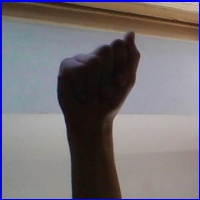

Expected category no : A
Response: [[7.688182353973389, 3.9646029472351074, 0.9547290802001953, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5011566877365112, 0.0, 3.566728353500366, 2.2505133152008057, 0.0, 0.0, 0.0, 0.0, 0.310312956571579, 4.681624412536621, 4.327795505523682, 0.0, 0.0, 0.0, 4.636252403259277, 2.499082326889038, 0.0, 0.0, 0.0, 2.8500635623931885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
----------------------------------------------------------------------
-----------------------------------------------------

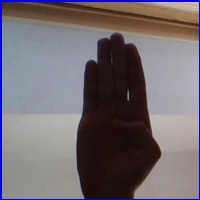

Expected category no : B
Response: [[0.0, 10.367291450500488, 0.0, 0.0, 0.0, 0.0, 0.0, 0.598381757736206, 0.0, 0.8182090520858765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3108114004135132, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
----------------------------------------------------------------------
----------------------------------------------------------------------
Response/Inference for the above image is : 'B'
------------------------------------------------

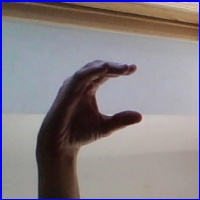

Expected category no : C
Response: [[0.0, 0.0, 10.699620246887207, 3.797069549560547, 0.0, 0.0, 0.0, 0.4872783422470093, 0.0, 0.0, 0.0, 5.143039703369141, 0.0, 0.0, 0.0, 0.3721250891685486, 1.5564589500427246, 0.0, 0.0, 1.8282265663146973, 0.0, 0.0, 0.0, 0.7803218960762024, 0.0, 0.0, 0.0, 0.0, 4.661263942718506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
----------------------------------------------------------------------
Response/Inference for the above image is : 'C'
----------------------------------------------

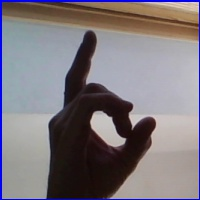

Expected category no : D
Response: [[0.0, 0.0, 3.358764410018921, 8.803892135620117, 0.0, 2.419361114501953, 0.0, 0.39468228816986084, 0.0, 3.692802667617798, 0.3554805815219879, 0.0, 0.0, 0.0, 0.21633651852607727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.43845969438552856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : 'D'
----------------------------------------------------------------------
-----------------------------------------------------------

In [32]:
#Testing the deployed endpoint using some test images
#Solution 1: Using the Predictor object directly.
from PIL import Image
import io
import os
import numpy as np

test_dir = "./asl_alphabet/test/"
#test_images = ["D/D10.jpg", "C/C30.jpg", "B/B11.jpg", "A/A10.jpg"]
test_images = ["A/A5.jpg", "B/B11.jpg","C/C30.jpg", "D/D10.jpg"]
test_images_expected_output = ['A', 'B', 'C', 'D' ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected category no : {expected_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_category = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        if predicted_category == 4:
            print(f"Response/Inference for the above image is : 'D'")
        print("----------------------------------------------------------------------")
        if predicted_category == 3:
            print(f"Response/Inference for the above image is : 'C'")
        print("----------------------------------------------------------------------")
        if predicted_category == 2:
            print(f"Response/Inference for the above image is : 'B'")
        print("----------------------------------------------------------------------")
        if predicted_category == 1:
            print(f"Response/Inference for the above image is : 'A'")
        print("----------------------------------------------------------------------")

# We have taken 4 test samples, and our model has righly predicted the results.


# Data capture

In [58]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = "s3://sagemaker-us-east-1-910293992207/data_capture/pytorch-inference-2023-02-10-05-41-51-640/AllTraffic/2023/02/10/05/"

S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data

In [59]:
data_path = "s3://sagemaker-us-east-1-910293992207/data_capture/pytorch-inference-2023-02-10-05-41-51-640/AllTraffic/2023/02/10/06/"

S3Downloader.download(data_path, "captured_data")


In [60]:
data_path = "s3://sagemaker-us-east-1-910293992207/data_capture/pytorch-inference-2023-02-10-05-41-51-640/AllTraffic/2023/02/10/07"

S3Downloader.download(data_path, "captured_data")


In [41]:
!pip install jsonlines
import jsonlines

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [42]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

In [38]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-inference-2023-02-10-05-41-51-640


In [62]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()